# COURSE: A deep understanding of deep learning

## SECTION: ANNs

### LECTURE: Learning rates comparison

#### TEACHER: Mike X Cohen, sincxpress.com

##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202210


In [1]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def t2f(x: torch.Tensor) -> np.ndarray:
    return x.detach().cpu().numpy().flatten()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Create the data


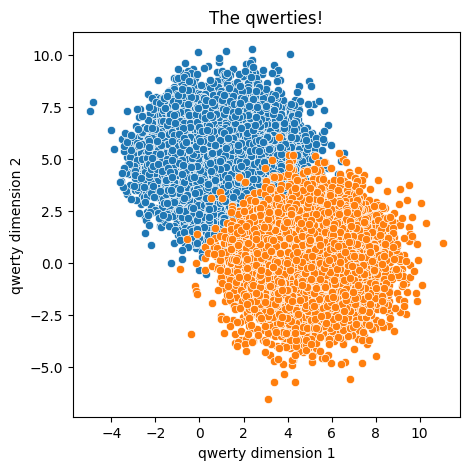

In [2]:
# create data

n_per_clust = 10000
blur = 1.5

A = [1, 5]
B = [5, 0]

# generate data
a = [
    A[0] + np.random.randn(n_per_clust) * blur,
    A[1] + np.random.randn(n_per_clust) * blur,
]
b = [
    B[0] + np.random.randn(n_per_clust) * blur,
    B[1] + np.random.randn(n_per_clust) * blur,
]

# true labels
labels_np = np.hstack((np.zeros((n_per_clust)), np.ones((n_per_clust))))

# concatanate into a matrix
data_np = np.hstack((a, b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np, device=device).float()
labels = torch.tensor(labels_np, device=device).float().reshape(-1, 1)

# show the data
plt.figure(figsize=(5, 5))
sns.scatterplot(x=data_np[labels_np == 0, 0], y=data_np[labels_np == 0, 1])
sns.scatterplot(x=data_np[labels_np == 1, 0], y=data_np[labels_np == 1, 1])
plt.title("The qwerties!")
plt.xlabel("qwerty dimension 1")
plt.ylabel("qwerty dimension 2")
plt.show()


# Functions to build and train the model


In [3]:
def createANNmodel(learningRate):
    # model architecture
    ANNclassify = nn.Sequential(
        nn.Linear(2, 1),  # input layer
        nn.ReLU(),  # activation unit
        nn.Linear(1, 1),  # output unit
        # nn.Sigmoid(),    # final activation unit (not needed b/c we use BCEWithLogitsLoss)
    ).to(device)

    # loss function
    lossfun = nn.BCEWithLogitsLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNclassify.parameters(), lr=learningRate)

    # model output
    return ANNclassify, lossfun, optimizer


In [4]:
def trainTheModel(ANNmodel, lossfun, optimizer, num_epochs):
    try:
        losses
    except NameError:
        losses = torch.zeros(0, device=device)

    # loop over epochs
    for epochi in range(num_epochs):

        # forward pass
        yHat = ANNmodel(data)

        # compute loss
        loss = lossfun(yHat, labels)
        losses = torch.cat((losses, loss.view(1)), 0)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # final forward pass
    predictions = ANNmodel(data)

    # compute the predictions and report accuracy
    # NOTE: shouldn't it be predictions>.5??
    totalacc = 100 * torch.mean(((predictions > 0) == labels).float())

    return losses, predictions, totalacc


# Test the new code by running it once


Final accuracy: 49.60%


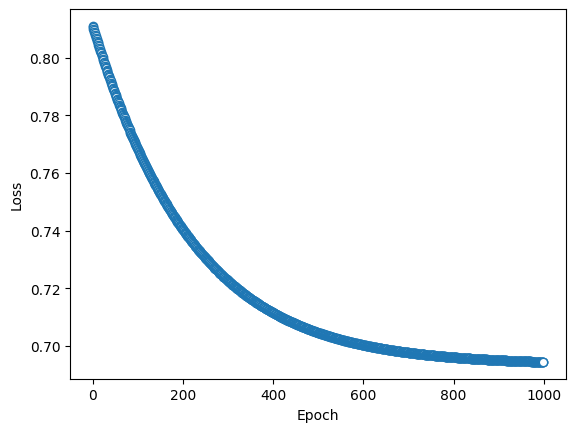

In [5]:
ANNclassify, lossfun, optimizer = createANNmodel(0.01)
losses, predictions, totalacc = trainTheModel(ANNclassify, lossfun, optimizer, 1000)
print(f"Final accuracy: {totalacc:0.2f}%")

plt.plot(t2f(losses), "o", markerfacecolor="w", linewidth=0.1)
plt.xlabel("Epoch"), plt.ylabel("Loss")
plt.show()

# Now for the experiment


In [8]:
num_epochs = 1000
# the set of learning rates to test
learning_rates = np.linspace(0.001, 0.1, 40)

# initialize results output
acc_by_lr = np.zeros((len(learning_rates)))
all_losses = np.zeros((len(learning_rates), num_epochs))


# loop through learning rates
for i, lr in enumerate(learning_rates):

    # create and run the model
    ANNclassify, lossfun, optimizer = createANNmodel(lr)
    losses, predictions, totalacc = trainTheModel(ANNclassify, lossfun, optimizer, num_epochs)

    # store the results
    acc_by_lr[i] = (t2f(totalacc))
    all_losses[i, :] = t2f(losses)


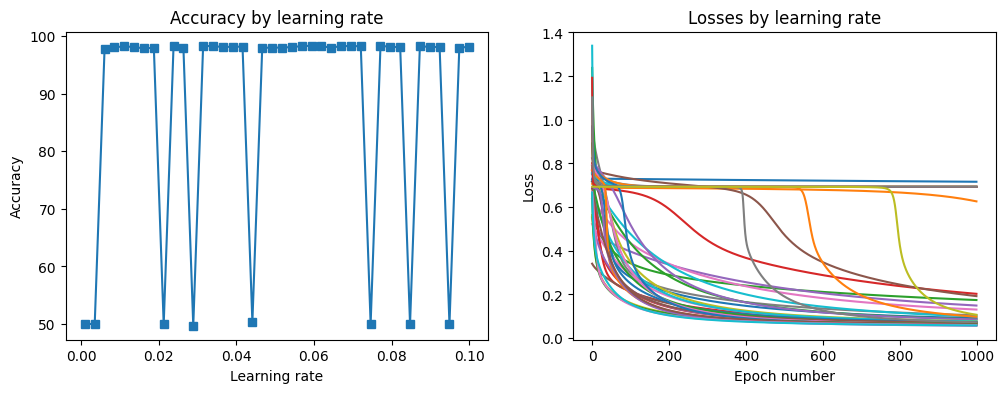

In [9]:
# plot the results
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(learning_rates, acc_by_lr, "s-")
ax[0].set_xlabel("Learning rate")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Accuracy by learning rate")

ax[1].plot(all_losses.T)
ax[1].set_title("Losses by learning rate")
ax[1].set_xlabel("Epoch number")
ax[1].set_ylabel("Loss")
plt.show()


In [10]:
# proportion of runs where the model had at least 70% accuracy
sum(torch.tensor(acc_by_lr) > 70) / len(acc_by_lr)


tensor(0.8000)

# Run a meta-experiment to get more reliable results


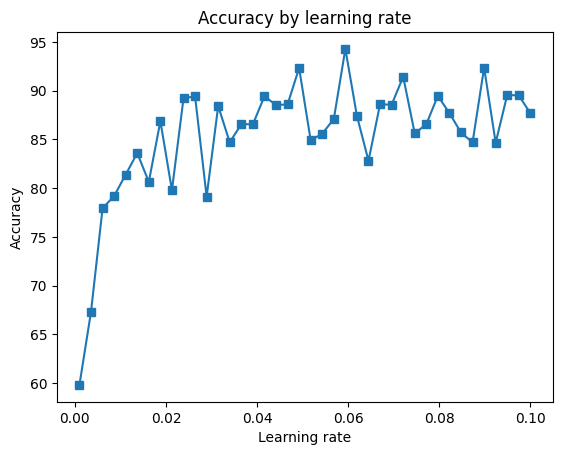

In [12]:
# run a "meta-experiment" by repeating the experiment N times
#  (different random weight initializations each time)
# note: this cell takes ~7 mins.

# number of times to iterate through the experiment
numExps = 50

# matrix to store all results
accMeta = np.zeros((numExps, len(learning_rates)))

# fewer epochs to reduce computation time
num_epochs = 500

# now for the experiment
for expi in range(numExps):
    for i, lr in enumerate(learning_rates):

        # create and run the model
        ANNclassify, lossfun, optimizer = createANNmodel(lr)
        losses, predictions, totalacc = trainTheModel(ANNclassify, lossfun, optimizer, num_epochs)

        # store the results
        accMeta[expi, i] = totalacc


# now plot the results, averaged over experiments
plt.plot(learning_rates, np.mean(accMeta, axis=0), "s-")
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")
plt.title("Accuracy by learning rate")
plt.show()


# Additional explorations


In [ ]:
# 1) The closeness of the qwerties groups is determined by the XY locations of the centroids, and by the blur parameter.
#    Try increasing or decreasing the blur (e.g., to 2 or .5). How does this affect the number of times that the model
#    successfully learned to categorize the two conditions?
#
# 2) The mean of a set of numbers is easily interpretable only if the data are roughly normally or uniformly distributed
#    (see lecture "Mean and variance" in Math section). Do you think the mean is a valid description of the performance
#    of the model's accuracy in the meta-experiment? Use a different metric (e.g., one we discussed in this video!) and
#    plot that result on the same graph as the average. You might need to do some normalization to get them in the same
#    range. Does this alternative method lead to a different conclusion?
#
# 3) Related to the previous comment, perhaps showing an image of the performance (variable accMeta) would be more
#    appropriate. Create a heat map that shows learning rate on the x-axis, experiment repetitions on the y-axis, and
#    the final accuracy in color. Label the axes and specify suitable color boundaries.
#
